# Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

#setup default plotting settings
plt.style.use('seaborn-darkgrid')
plt.rc('font', family='serif', size=14)
plt.rc('legend', framealpha=1,  facecolor='white', frameon=True)

# Read Data

In [2]:
df = pd.read_csv('voltage_current_data.csv', index_col='time')
df.head()

,voltage,current
time,,
0.000000,-0.014255,0.010500
0.000006,-0.014255,-0.016167
0.000012,0.005025,-0.016167
0.000018,-0.033535,-0.042833
0.000024,0.005025,-0.016167


# Plot Raw Data

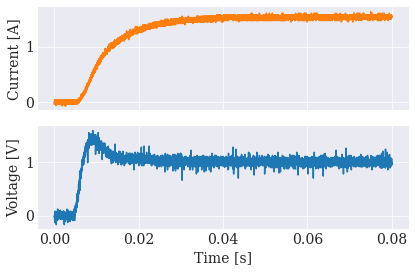

In [3]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(df['current'], color='C1')
ax2.plot(df['voltage'], color='C0')

ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Voltage [V]')
ax1.set_ylabel('Current [A]')

fig.tight_layout()
fig.savefig('plots/plot_01.png')

# Create Class for LR Load

Class is callable with input being time and state variable

In [4]:
class RL_Load():
    
    def __init__(self, L, R):
        
        self.L = L
        self.R = R
        self.V = None
        
    def di_dt(self, V, i):
        
        return (V - self.R*i)/self.L
    
    def set_applied_voltage(self, V):
        self.V = V
        
    def __call__(self, t, i):
        
        if self.V is not None:
            return self.di_dt(self.V(t), i)    


Call method directly to get current derivative

In [5]:
rl = RL_Load(L=0.001, R=0.5)
rl.di_dt(1,0)

1000.0

Set applied voltage function

In [6]:
rl = RL_Load(L=0.001, R=0.5)
V_step = lambda t: t>0.01 #step function
rl.set_applied_voltage(V_step)
rl(1,0)

1000.0

# Simulate Step response (randomly chosen RL load):

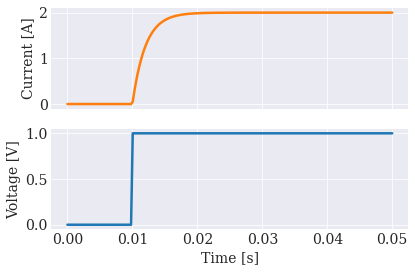

In [7]:
obj = solve_ivp(rl, (0, 0.05), y0=[0], t_eval = np.linspace(0,0.05,200),
                max_step=1e-4)

t, i = obj.t, obj.y.flatten()

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(t, i, color='C1', lw=2.5)
ax2.plot(t, V_step(t), color='C0', lw=2.5)

ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Voltage [V]')
ax1.set_ylabel('Current [A]')

fig.tight_layout()
fig.savefig('plots/plot_02.png')

# Apply actual experimental voltage waveform (randomly chosen RL load)

In [8]:
def plot_rl_response(rl, exp_data):

    obj = solve_ivp(rl, (0, exp_data.index.max()), 
                    y0=[0], t_eval = np.linspace(0,exp_data.index.max(),200),
                    max_step=1e-4)
    
    t, i = obj.t, obj.y.flatten()

    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    ax1.plot(exp_data['current'], color='C1', lw=2.5, label='Measured')
    ax1.plot(t, i, color='black', lw=2.5, label='Simulated')
    ax2.plot(exp_data['voltage'], color='C0', lw=2.5)

    ax1.legend(fontsize=11)

    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Voltage [V]')
    ax1.set_ylabel('Current [A]')

    fig.tight_layout()
    return fig, (ax1, ax2)

In [9]:
#convert discrete voltage data into continuous function using interpolation class
V_func = interp1d(df.index, df['voltage'])
V_func(0.05)

array(1.02686512)

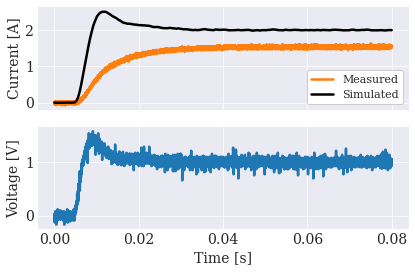

In [10]:
rl = RL_Load(0.001, 0.5)
rl.set_applied_voltage(V_func)

fig, (ax1, ax2) = plot_rl_response(rl, df)
fig.savefig('plots/plot_03.png')

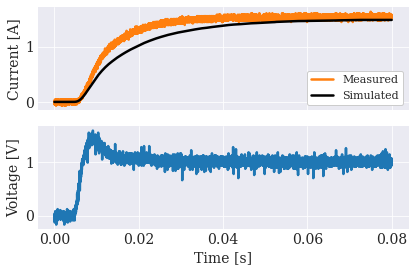

In [11]:
I_ss = 1.5 #steady state current
R_0 = 1/I_ss #initial resistance guess
tau = 0.035/5 #circuit time constant
L_0 = tau/R_0 #initial inductance guess

#update rl load object attributes
rl.R = R_0
rl.L = L_0

fig, (ax1, ax2) = plot_rl_response(rl, df)
fig.savefig('plots/plot_04.png')

# Create Cost Function to Measure how Good the Parameters Are:

In [12]:
class CostFunc():
    
    def __init__(self, exp_data):
        
        self.data = exp_data
        self.v_func = interp1d(self.data.index, self.data['voltage'])
        self.i_func = interp1d(self.data.index, self.data['current'])
        
        self.t_start = self.data.index[0]
        self.t_stop = self.data.index[-1]
        
        self.N = 200 #number of simulation data points
        
    def __call__(self,x):
        
        L, R, i0 = x
        self.lr_obj = RL_Load(L, R)
        self.lr_obj.set_applied_voltage(self.v_func)
        
        obj = solve_ivp(self.lr_obj, (self.t_start, self.t_stop), y0=[i0], 
                        t_eval = np.linspace(self.t_start, self.t_stop, self.N),
                        max_step=1e-4)

        err_squared = (obj.y - self.i_func(obj.t))**2
        return err_squared.sum()/self.N   

In [13]:
cost = CostFunc(df)
cost([0.01, 1, 0])

0.2267900268717348

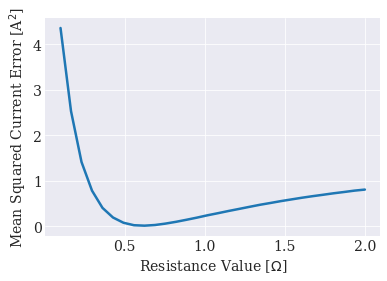

In [15]:
r_arr = np.linspace(0.1, 2, 30)
cst = []
for r in r_arr:
    cst.append(cost([0.01, r, 0]))

fig, ax = plt.subplots()
ax.plot(r_arr, cst, lw=2.5)
ax.set_xlabel('Resistance Value [$\Omega$]')
ax.set_ylabel('Mean Squared Current Error [A$^2$]');
fig.savefig('plots/plot_05.png')

# Find optimal parameters by minimizing cost function

In [16]:
def optimize(L_0, R_0, exp_data):
    res = minimize(CostFunc(exp_data), x0 = [L_0, R_0, 0], method = 'Nelder-Mead')
    L,R,I0 = res.x[0], res.x[1], res.x[2]
    
    if res.success:
        print(f'Inductance: {L}')
        print(f'Resistance: {R}')
        return L, R

In [17]:
L_opt, R_opt = optimize(L_0, R_0, df)

Inductance: 0.006789185098523318
Resistance: 0.6482958981753615


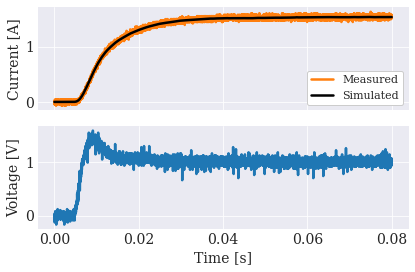

In [18]:
rl_opt = RL_Load(L_opt, R_opt)
rl_opt.set_applied_voltage(V_func)

fig, (ax1, ax2) = plot_rl_response(rl_opt, df)
fig.savefig('plots/plot_06.png')